In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist  
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import time

Загрузим датасет из базы данных рукописных цифр MNIST:

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Каждое изображения имеет разрешение 28x28 пикселей и представлено в черной-белом цвете.

(28, 28)


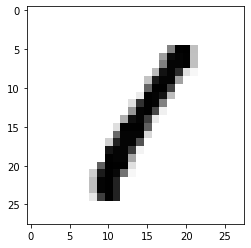

In [ ]:
#рассмотрим пример такого изображения
plt.imshow(train_images[3], cmap=plt.cm.binary)
print(train_images[3].shape)

Нейронная сеть гораздо быстрее работает со значениями, находящимися в диапазоне от 0 до 1, поэтому стандартизируем наши данные, чтобы наибольшее значение было равно 1:

In [ ]:
#стандартизируем входные данные
train_images = train_images / 255
test_images = test_images / 255

Преобразуем лейблы наших изображений в векторы размерности 10x1. Для i-ого лейбла вектор выглядит следующим образом: на i-ой позиции стоит 1, а на всех остальных - 0.

In [ ]:
train_labels_cat = keras.utils.to_categorical(train_labels, 10)
test_labels_cat = keras.utils.to_categorical(test_labels, 10)

In [ ]:
#рассмотрим пример 
print(train_labels[3])
print(train_labels_cat[3])
print(train_labels_cat[3].shape)

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(10,)


На вход сверточному слою нейросети подается тензор размерности 4, поэтому нам необходимо к обучающей и тестовой выборке добавить одну размерность:

In [ ]:
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

Используя метод Sequential из библиотеки keras, создаем модель нашей нейросети. Она состоит из семи слоев, пять из которых скрытые. 
Первые четыре слоя - сверточные, последующие три слоя составляют простейшую полносвязную нейросеть, в которую передается вектор размерности 3. 
По концепции сверточных нейронных сетей: каждый последующий слой должен укрупнять масштаб полученных признаков, поэтому после сверточного слоя Conv2D идет слой MaxPooling2D, который выбирает максимальные значения из квадратов, выбранного размера, уменьшая карту признаков.

In [ ]:
model = keras.Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10,  activation='softmax')
])

Так как наша задача состоит в классификации изображений более чем на 2 класса, а также функция softmax является функцией активации для выходного слоя, в качестве критерия качества мы будем использовать категориальную кроссэнтропию.

In [ ]:
model.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Начнем обучение нашей модели на обучающих данных. В датасете из библиотеки
MNIST 60, 000 изображений составляют обучающую выборку. Мы разделим эту выборку на два класса - непосредственно обучающую выборку и выборку валидации, которая будет составлять 20% от общего объема обучающей выборки (12, 000 изображений).

In [ ]:
t=time.time()
fit = model.fit(train_images, train_labels_cat, batch_size=32, epochs=5, validation_split = 0.2)
t = time.time() - t

print("Время обучения модели: ", t, "с")

Epoch 1/5
1500/1500 [==============================] - 60s 40ms/step - loss: 0.1457 - accuracy: 0.9542 - val_loss: 0.0555 - val_accuracy: 0.9841
Epoch 2/5
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0453 - accuracy: 0.9859 - val_loss: 0.0416 - val_accuracy: 0.9873
Epoch 3/5
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.0424 - val_accuracy: 0.9861
Epoch 4/5
1500/1500 [==============================] - 59s 39ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0700 - val_accuracy: 0.9817
Epoch 5/5
1500/1500 [==============================] - 59s 39ms/step - loss: 0.0164 - accuracy: 0.9943 - val_loss: 0.0451 - val_accuracy: 0.9877
Время обучения модели:  298.8758330345154 с


Оценим работу нашей модели на тестовой выборке (она составляет 10, 000 изображений):

In [ ]:
eval = model.evaluate(test_images, test_labels_cat)

313/313 [==============================] - 4s 12ms/step - loss: 0.0386 - accuracy: 0.9875


In [ ]:
print("Точность: {}%".format(round(eval[1]*100,4)))

Точность: 98.75%


Построим графики точности и потерь на каждой итерации:



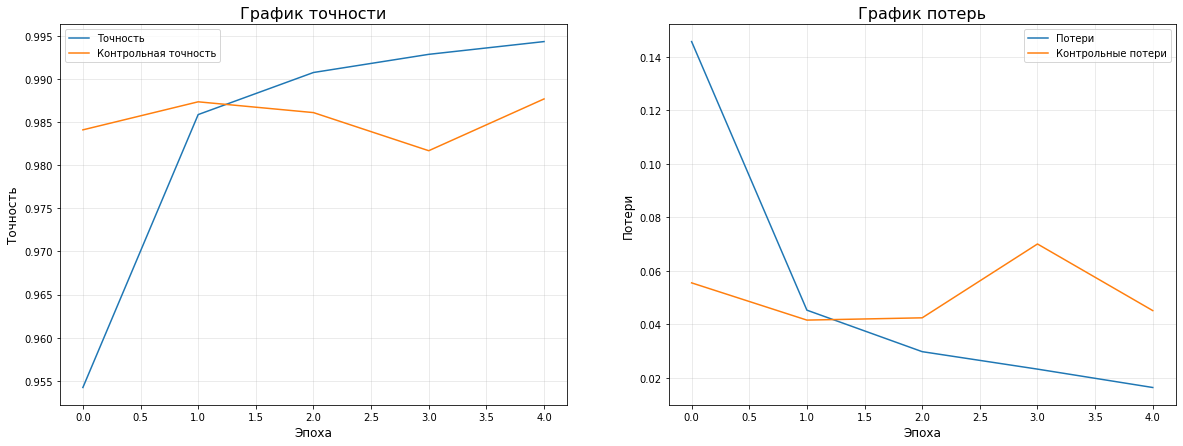

In [ ]:
f = plt.figure(figsize=(20,7))

 
f.add_subplot(121)

plt.plot(fit.epoch, fit.history['accuracy'], label = "Точность") 
plt.plot(fit.epoch, fit.history['val_accuracy'], label = "Контрольная точность")  

plt.title("График точности", fontsize=16)
plt.xlabel("Эпоха", fontsize=12)
plt.ylabel("Точность", fontsize=12)
plt.grid(alpha = 0.3)
plt.legend()

 
f.add_subplot(122)

plt.plot(fit.epoch, fit.history['loss'], label = "Потери") 
plt.plot(fit.epoch, fit.history['val_loss'], label = "Контрольные потери") 
plt.title("График потерь", fontsize=16)
plt.xlabel("Эпоха", fontsize=12)
plt.ylabel("Потери", fontsize=12)
plt.grid(alpha = 0.3)
plt.legend()

plt.show()

In [ ]:
files.upload()

KeyboardInterrupt: ignored

Проверим работу нашей нейронной сети на изображениях, которые не участвовали в обучении, и определим ее точность:

[]

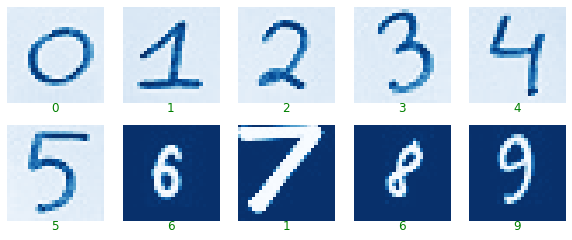

In [ ]:
correct = 0

wrong_img = []
wrong_labels = []

rows = 2
cols = 5

f = plt.figure(figsize=(2*cols, 2*rows))

for i in range(rows * cols): 
    img = load_img(f'{i}.jpg')
    img_array = img_to_array(img)
    img_array = img_array / 255
    img_array = img_array[:,:,:1].reshape([1,28,28,1])
    pred = np.argmax(model.predict(img_array), axis = 1)[0]
    
    f.add_subplot(rows,cols,i+1)
    img_array=img_array.reshape([28,28])
    plt.imshow(img_array, cmap="Blues") 
    plt.axis("off")
    plt.title("{}".format(pred), y=-0.15, color="green")

    if i == pred:
      correct += 1

    if i != pred:
      wrong_img.append(img_array)
      wrong_labels.append(pred)

plt.plot()

In [ ]:
print("Точность распознавания изображений не участвовавших в обучении: ", (correct / 10)*100, "%")

Точность распознавания изображений не участвовавших в обучении:  80.0 %


Выведем изображения цифр, которые нейросеть распознала неверно:

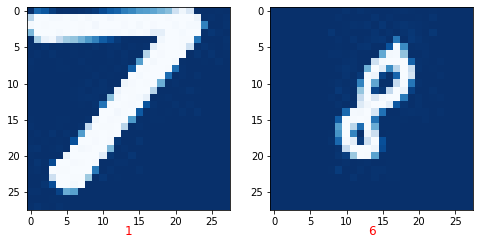

In [ ]:
f = plt.figure(figsize=(8, 4))

n = 10 - correct

for i in range(n):
  f.add_subplot(1,n,i+1)
  plt.imshow(wrong_img[i], cmap="Blues") 
  plt.title("{}".format(wrong_labels[i]), y=-0.15, color="red")

Сохраним нашу модель:

In [ ]:
model.save('model.h5')